In [1]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
# from matplotlib import cm

import matplotlib as mpl
mpl.rcParams["mathtext.default"] = 'regular'

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    print(target.params['target'],target.params['Inputs'],
                       target.params['Spath'])
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)

class ResultMap:
    def __init__(self,Path,target,Test='N/A',Rule=1,alpha = .025,DataName = 'AllData.csv', AltPath=None,Site='FishIsland',FPVars=None):
        self.FPVars = FPVars
        self.target = target        
        self.params = Dense.Params(Path,'Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName,FPVars = FPVars)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+AltPath+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'           
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Nodes'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        self.Best = self.Records.loc[self.Records.index==Rule]
        self.Model_Selection = self.Best['Model'].values[0]
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
#         pool = Pool(processes=1,maxtasksperchild=75) 
#         for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):

        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
#             self.Model=results[1]
#             YVar = self.RST.YvarScaled.inverse_transform(YVar)    
            YVar = YStandard.inverse_transform(YVar)                    
#         pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     
    # print(fch4.RST.X_fill.shape)


SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:#,'ER']:
        try:
            AllRes[f]={}
            AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
            AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        #         temp=open(Path+f+'_Removed.txt', "r")
        #         AllRes[f]['Removed'] = temp.read().split(',')
            AllRes[f]['Derivatives']={}
            AllRes[f]['SSQ'] ={}
            AllRes[f]['X'] = {}
            AllRes[f]['Yhat'] = {}
            AllRes[f]['Ytrue'] = {}
            AllRes[f]['Outputs'] = {}
        except:
            pass
    return(AllRes)

def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)

Variables=['H','LE','fco2','fch4',
           'wind_speed','air_pressure','AirTC_Avg','NR_Wm2_Avg',
           'PPFD_Avg',
           'Table_1','Temp_2_5_1','Temp_2_5_2','Temp_5_1',
           'Temp_5_2','Temp_15_1','Temp_15_2','Ts All Cent',
           'Ts All Rim','VWC_2','VWC_1','Active_Layer_1','24H Rain',
           'wind_dir','ER','Time','DOY',
           'VPD','u*','Wind_Direction','Delta_Table_1',
           'Rolling_Temp_15_1','Delta_air_pressure','Anoxic_Depth','Ratio',
           'Active_Layer_2','Rolling_NR_Wm2_Avg',
              'Rim','Collapse','Polygon','Daytime','nan']
Aliases=['Sensible Heat Flux','Latent Heat Flux','Net Ecosystem Exchange','Net Methante Exchange',
         'Wind Speed','Air Pressure','Air Temperature','Net Radiation',
         'Photon Flux Density',
         'Water Table Depth','Polygon Center T$_{s}$ 2.5cm','Polygon Rim T$_{s}$ 2.5cm','Polygon Center T$_{s}$ 5cm',
         'Polygon Rim T$_{s}$ 5cm','Polygon Center T$_{s}$ 15cm','Polygon Rim T$_{s}$ 15cm','Ts All Cent',
         'Ts All Rim','Volumetric Water Content (Rim)','VWC Polygon Center','Thaw Depth','24H Rain','Dir','Ecosystem Respiration','Time','Day of Year',
         'Vapor Pressure Deficit','Friction Velocity','Wind Direction','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'Rim Fraction','Tro Fraction','Cnt Fraction','Daytime','nan']


Abbreviations=['H','LE','NEE','NME',
         'U','Pa','T$_{a}$','Rn',
         'PPFD',
         'W$_{TD}$','T$_{Cnt 2.5}$','T$_{Rim 2.5}$','T$_{Cnt 5}$',
         'T$_{Rim 5}$','T$_{Cnt 15}$','T$_{Rim 15}$','Ts All Cent',
         'Ts All Rim','VWC$_{Rim}$','VWC$_{Cnt}$','TD','24H Rain','Dir','ER','Time','DOY','VPD','u$^*$','Wind Dir','DW$_{TD}$',
         'Mean T$_{s 15 cm Cnt}$','Dpa','Anoxic Depth','Ratio','Active_Layer_2','Mean Rn',
         'F$_{Rim}$','F$_{Tro}$','F$_{Cnt}$','Daytime','nan']


NameDict = {}
for k,n in zip(Variables,Aliases):
    NameDict[k]=n
    
AbbrevDict = {}
for k,n in zip(Variables,Abbreviations):
    AbbrevDict[k]=n 

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using TensorFlow backend.


In [2]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
# Site = 'FishIsland_Paper/'
# Site = 'FishIsland_Keep/'
# Site = 'FishIsland_BL_Flaw/'
# File_Name = 'Data_Footprints_2021-09-24_2000mx2m.csv'
Site = 'FishIsland/'
File_Name = 'Data_Footprints_2021-09-26_2000mx2m.csv'
File_Name = 'Data_Footprints_2022-02-16_2000mx2m.csv'
File_Name = 'FI_Footprints_2022-02-23_2000mx2m.csv'
Path = Path+Site
AllRes = RecRead(Path = Path) 

for i,F in enumerate(['fco2','fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
    #     print(I)
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    print(df[['Factor','R2','RMSE','SE','Diff','MBE','PCT']].round(4)[::-1])
    
#       Factor      R2    RMSE      SE    Diff     MBE     PCT
# 21_75    N/A  0.9458  0.3473  0.0029     NaN -0.0038  1.0000
# 8_75     N/A  0.9306  0.3932  0.0022  0.0458  0.0033  0.8834
#       Factor      R2    RMSE      SE    Diff     MBE    PCT
# 21_43    N/A  0.7428  6.3838  0.0459     NaN  0.0664  1.000
# 8_43     N/A  0.7306  6.5342  0.0472  0.1504  0.0555  0.977




      Factor      R2    RMSE      SE    Diff     MBE     PCT
21_75    N/A  0.9460  0.3467  0.0028     NaN -0.0033  1.0000
8_75     N/A  0.9305  0.3933  0.0022  0.0465  0.0022  0.8817
      Factor      R2    RMSE      SE  Diff     MBE     PCT
21_43    N/A  0.7432  6.3792  0.0489   NaN  0.0506  1.0000
8_43     N/A  0.7302  6.5392  0.0468  0.16  0.0538  0.9755


In [3]:

co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'

# Gap filling etc!

In [4]:
Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'
FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
# fch4_proj = ResultMap(Path,'fch4_dummy',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,AltPath='fch4',FPVars=FPVars)
ER = ResultMap(Path,'ER',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,AltPath='fco2',FPVars=FPVars)
T30 = fco2.RST.Master.copy()

In [5]:
print(fco2.Model_Selection.split('+'))
print(fch4.Model_Selection.split('+'))
T30.loc[T30['fch4'].isnull()==False,['Polygon','Rim','Collapse','FarField']].describe().round(5)

['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime']
['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim']


,Polygon,Rim,Collapse,FarField
count,1441.00000,1441.00000,1441.00000,1441.00000
mean,0.61390,0.24292,0.03355,0.10963
std,0.05697,0.06875,0.01945,0.00842
min,0.33021,0.05057,0.00001,0.07289
25%,0.58717,0.20638,0.01759,0.10509
50%,0.62840,0.22446,0.03370,0.10960
75%,0.63707,0.28334,0.04836,0.11354
max,0.77463,0.56351,0.09384,0.18082


In [6]:

mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1,#,#(1e-9 * 12.0107 *1800)
        'fch4_dummy':1
       }
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

T30_Dark = T30.copy()
T30_Dark['PPFD_Avg'] = 0
T30_Dark['Daytime'] = 0
T30_Dark.loc[T30_Dark['NR_Wm2_Avg']>0,'NR_Wm2_Avg'] = 0#T30['NR_Wm2_Avg'].min()
T30 = Mapper(T30,ER,'ER_est',Fill = False,DarkTarget=T30_Dark)



C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


FloatProgress(value=0.0, description='Running:', max=30.0)

C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


FloatProgress(value=0.0, description='Running:', max=30.0)

C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarni

ER ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


FloatProgress(value=0.0, description='Running:', max=30.0)

C:\Anaconda3\lib\site-packages\sklearn\base.py:318: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [7]:

# T30_LC = T30.copy()
# T30_LC['Rim'] = T30_LC['Rim']-T30_LC['Rim'].min()
# T30 = Mapper(T30,fch4_proj,'NME_est_proj',Fill = False,DarkTarget=T30_LC)

In [8]:
# T30['NME_est_proj_1']

In [9]:
for target,name in zip([fch4,fco2,ER],['NME','NEE','ER','NME_est_proj']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)

for target,name in zip([fch4,fco2,ER],['NME_est','NEE_est','ER_est','NME_est_proj']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')
print(T30['ER_est'].mean())
print(T30['NEE_est'].mean())
print(T30['ER'].mean())
print(T30['NEE'].mean())
T30['GPP_est'] = T30['ER_est'] - T30['NEE_est']
T30['GPP'] = T30['ER'] - T30['NEE']

# 1.5422903299331665
# -0.604559063911438
# 1.5423612284782753
# -0.6014440377954352


NME
NEE
ER
Done
Done
1.5170648097991943
-0.5941725373268127
0.0
-0.5932994591111586


In [10]:

mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':1,#,#(1e-9 * 12.0107 *1800)
        'fch4_dummy':1
       }

In [11]:
def MI(Data,Vars,JustBetween=False):
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'NME':fch4,
           'NEE_est':fco2,
           'NME_est':fch4,
#            'ER_est':ER,
           'ER':ER,
#            'NME_est_proj':fch4_proj
          }
for Var in ['NEE_est',
            'NME_est',
            'ER',
            ]:#,
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER' or Var == 'NME_est_proj':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5*1*mult[target.target]
#         print((std/Temp.shape[0]**.5)*1*mult[target.target]*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
        if Var == 'ER':
            Int=Temp[Var+'_est_CI'].mean()

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*1
#         Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())

        Int=Temp[Var+'_CI'].mean()
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/1)#*mult[target.target]
    print(Temp[Var].sum(),(Temp.shape[0]/1),U)
    print()
#     if target == 'ER':
#         U*= mult[target.target]
    Estimates.append(U)
    CIs.append(Int)

    Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
    
std = MI(Temp,Cols)**.5
Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
print(Temp['CBal'].mean()*1,Int*1)
    
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}

print(Estimates[0]+Estimates[1])

All = pd.DataFrame(data = Data)

# print((All['Estimates'].iloc[0]-All['Estimates'].iloc[2])*-1)

T30.to_csv('G:/My Drive/FishIsland_Outputs/Skeeter_et_al_2022_Day_Fix.csv')

All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]


-2354.1096 3962.0 -0.5941720391571491

109772.22 3962.0 27.706264197375063

0.0 3962.0 0.0

27.112233695655835 0.34191373842884804
27.112092158217912


,Flux,Type,Scale,Estimates,SE,95% CI/PI
0,NEE,EC Obs.,Footprint,-0.594172,0.145864,0.277872
1,NME,EC Obs.,Footprint,27.706264,2.191496,4.192097
2,ER,EC Obs.,Footprint,0.000000,0.920419,0.751097


0.0014742550283805065
0.0015124437818764738
0.0010013732907931056
0.0007302147926639452


<IPython.core.display.Javascript object>


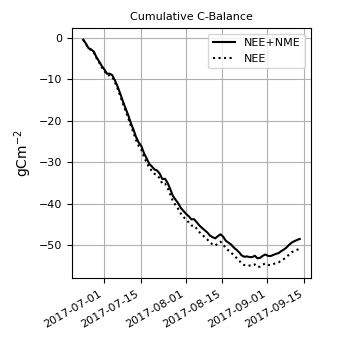

In [14]:
mult = {'fco2-c':(1e-6 * 12.0107 *3600),
        'fco2':(1e-6 * 44.0107 *3600),
        'ER':1,
        'fch4-c':(1e-9 * 12.0107 *3600),
        'fch4':(1e-9 * 16.04 *3600)}
print(T30.loc[T30.index.month==6,'NME'].mean()*mult['fch4-c'])
print(T30.loc[T30.index.month==7,'NME'].mean()*mult['fch4-c'])
print(T30.loc[T30.index.month==8,'NME'].mean()*mult['fch4-c'])
print(T30.loc[T30.index.month==9,'NME'].mean()*mult['fch4-c'])

cm=1/2.54
# print(T30.loc[((T30.index>='2017-07-11')&(T30.index<='2017-08-07')),['NEE','ER','NME']].mean()*mult['fco2-c']*24)

# print(4.3/mult['fch4'])
# print(12.5/mult['fch4'])
fig,ax = plt.subplots(1,sharex=True,figsize=(8.84*cm,8.84*cm))
D = (T30[['NEE','NME']]*mult['fco2-c']).resample('D').sum()/2
D['NME']=D['NME']*1e-3
# D['NME_est_proj']=D['NME_est_proj']*1e-3
D['Bal'] = D[['NEE','NME']].sum(axis=1)
# D['Bal_proj'] = D[['NEE','NME_est_proj']].sum(axis=1)
ax.plot(D['Bal'].cumsum(),color='k',label='NEE+NME')
# ax.plot(D['NME_est_proj'].cumsum(),color='r')
ax.plot(D['NEE'].cumsum(),color='k',linestyle=':',label='NEE')
ax.grid()
ax.set_title('Cumulative C-Balance')
ax.set_ylabel('$g C m^{-2}$')


plt.tight_layout()

plt.legend()
fig.autofmt_xdate()
plt.savefig('G:\\My Drive\\Misc_Stuff/FI_Manuscript/Fig11.jpg',dpi=600)
# x2=ax.twinx()

# 0.0014740065406990222
# 0.0015131465955740286
# 0.001001856819069355
# 0.0007278302483968744


In [ ]:
GPP = pd.read_csv('G:\\My Drive\\earthengine/GPP_PsnNet.csv',parse_dates=['date'],na_values=-9999,index_col=['date'])
GPP = GPP*0.0001*1e3

GPP = GPP.resample('30T').asfreq()
idx = T30.index.rename('datetime')
T30 = T30.set_index(idx.tz_localize(None))
T30=T30.join(GPP[['Gpp','PsnNet']],how='inner')#['Gpp'].max()/8/24/1e3/(1e-6 * 12.0107 *3600)

T30['NEE_8']=(T30['NEE_est']*mult['fco2-c']).rolling('8D').sum()/2
T30['ER_8']=(T30['ER_est']*mult['fco2-c']).rolling('8D').sum()/2

Temp = T30[['NEE_8','ER_8','Gpp','PsnNet']].dropna()
Temp['ER']=Temp['NEE_8']+Temp['Gpp']
print((Temp/8).round(4))
plt.figure()
plt.scatter(Temp['NEE_8'],Temp['Gpp'])

<IPython.core.display.Javascript object>


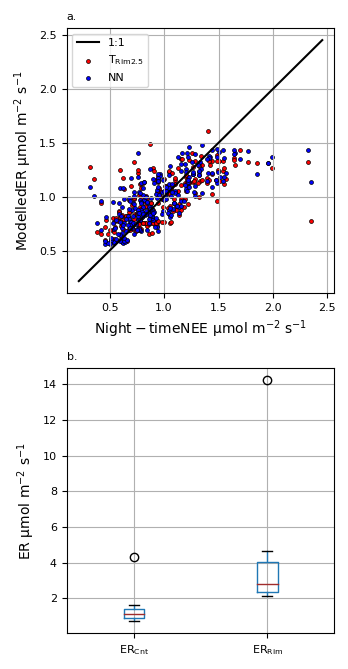

Temp_2_5_2 0.43321300922703876    0.2591615350005284
AirTC 0.3089236339451985    0.2861696861987123
NN 0.5500698533893529 0.23090490227172494
239


In [19]:

fig,ax=plt.subplots(2,1,figsize = (8.84*cm,17*cm))#,sharey=True)


class ChamberAnalysis:
    def __init__(self,ChamberPath,flux):
        self.Data = pd.read_csv(ChamberPath,delimiter = ',')
        self.Data.loc[self.Data['Position']==3,'Position']=1
ChamberPath = 'C:\\FishIsland_2017\\ChamberStationData/ChamberFluxes.csv'
flux = 'CO2 Flux (umol/m2/s)'


CH = ChamberAnalysis(ChamberPath,flux)
Data = CH.Data[['Position','Flux']].copy()

Temp = T30.loc[T30['Daytime']==0,['co2_flux']].copy().reset_index(drop=True)
Temp['Position']=3
Temp['Flux'] = Temp['co2_flux']

# Data = Data.append(Temp[['Position','Flux']])
    
bp0 = Data.boxplot(by='Position',ax=ax[1],return_type='dict')

[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
ax[1].set_title(None)
ax[1].set_title('b.',loc='left')
# ax[1].set_ylabel('${u}mol m^{-2} s^{-1}$')

ax[1].set_ylabel(r'$ER\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[1].set_xticklabels(['$ER_{Cnt}$','$ER_{Rim}$'])#,'Nighttime ER'])
ax[1].set_xlabel(None)
# ax
fig.suptitle(None)


Dark = T30.loc[T30['Daytime']==0,['co2_flux','ER_est','AirTC_Avg',
                                  'Temp_2_5_2','Temp_2_5_1','Temp_5_2','Temp_5_1','Temp_15_2','Temp_15_1']].dropna()

def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))

for Temp in ['Temp_2_5_1','Temp_5_2','Temp_5_1','Temp_15_2','Temp_15_1','Temp_2_5_2']:
#     print(Temp)
    popt_r, pcov = curve_fit(R_func, Dark[Temp], Dark['co2_flux'])
    R = metrics.r2_score(Dark['co2_flux'],R_func(Dark[Temp],*popt_r))
    if Temp == 'Temp_2_5_2':
        ax[0].scatter(Dark['co2_flux'],R_func(Dark[Temp],*popt_r),c='red',edgecolor='k',linewidth=.5,s=8,
                    label='$T_{Rim2.5}$')


popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['co2_flux'])
print(Temp,R,
  '  ',metrics.mean_squared_error(Dark['co2_flux'],R_func(Dark['Temp_2_5_2'],*popt_r))**.5)
print('AirTC' , metrics.r2_score(Dark['co2_flux'],R_func2(Dark['AirTC_Avg'],*popt_r2)),
      '  ',metrics.mean_squared_error(Dark['co2_flux'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
ax[0].scatter(Dark['co2_flux'],Dark['ER_est'],c='blue',edgecolor='k',linewidth=.5,s=8,
            label='NN')
ax[0].plot(ax[0].get_xlim(),ax[0].get_xlim(),color='k',label='1:1')


print('NN',metrics.r2_score(Dark['co2_flux'],Dark['ER_est']),metrics.mean_squared_error(Dark['co2_flux'],Dark['ER_est'])**.5)
ax[0].legend()
ax[0].set_xlabel(r'$Night-time NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].set_ylabel(r'$Modelled ER\ {\mu}mol\ m^{-2}\ s^{-1}$')
ax[0].grid()

ax[0].set_title('a.',loc='left')
print(Dark['co2_flux'].count())
plt.tight_layout()
# plt.savefig('
plt.savefig('G:\\My Drive\\Misc_Stuff/FI_Manuscript/Fig8_Revised.jpg',dpi = 600)

In [20]:
# print(T30.groupby('Daytime').count()[['NEE_est','fco2']])
print(T30.loc[((T30['Daytime']==0)&(T30['PPFD_Avg']>10)),'PPFD_Avg'])#.describe())


Series([], Name: PPFD_Avg, dtype: float64)


In [21]:
# ax[1].figure()
print(Data.groupby('Position').median())


C2 =((T30['Collapse']*1.092802).mean())
C3 =((T30['Collapse']*2.774963).mean())


C4 =((T30['FarField']*(.33*2.774963+.67*1.092802)).mean())

C5 =((T30['FarField']*(.37*2.774963+.63*1.092802)).mean())


C1 = ((T30['Polygon']*1.092802).mean())+((T30['Rim']*2.774963).mean())

print(C1 + C2 + C4)
print(C1 + C3 + C5)
print(T30.loc[((T30['Daytime']==1)&(T30.index.month<=7)&(T30.PPFD_Avg<=10)),'PPFD_Avg'].dropna().sort_values())

              Flux
Position          
1         1.092802
2         2.774963
1.5594701254154972
1.6253933345035594
2017-07-27 05:00:00    0.324
2017-07-27 05:30:00    0.664
2017-07-30 01:30:00    0.962
2017-07-21 03:00:00    1.784
2017-07-21 02:30:00    2.013
2017-07-21 03:30:00    2.034
2017-07-27 06:00:00    2.037
2017-07-21 04:30:00    2.054
2017-07-26 04:00:00    3.237
2017-07-21 04:00:00    3.622
2017-07-31 01:30:00    3.830
2017-07-25 02:30:00    3.946
2017-07-26 02:30:00    4.480
2017-07-21 00:30:00    4.520
2017-06-23 03:30:00    4.655
2017-07-24 04:30:00    4.660
2017-07-24 02:00:00    4.666
2017-07-24 05:00:00    4.673
2017-07-24 05:30:00    4.673
2017-07-24 03:30:00    4.673
2017-07-24 04:00:00    4.673
2017-07-26 04:30:00    4.675
2017-07-21 02:00:00    4.754
2017-07-25 04:00:00    4.785
2017-07-21 05:00:00    4.858
2017-07-21 00:00:00    5.108
2017-07-24 01:30:00    5.242
2017-07-31 05:00:00    5.442
2017-07-26 02:00:00    5.525
2017-07-31 01:00:00    5.532
2017-07-25 02:00

<IPython.core.display.Javascript object>


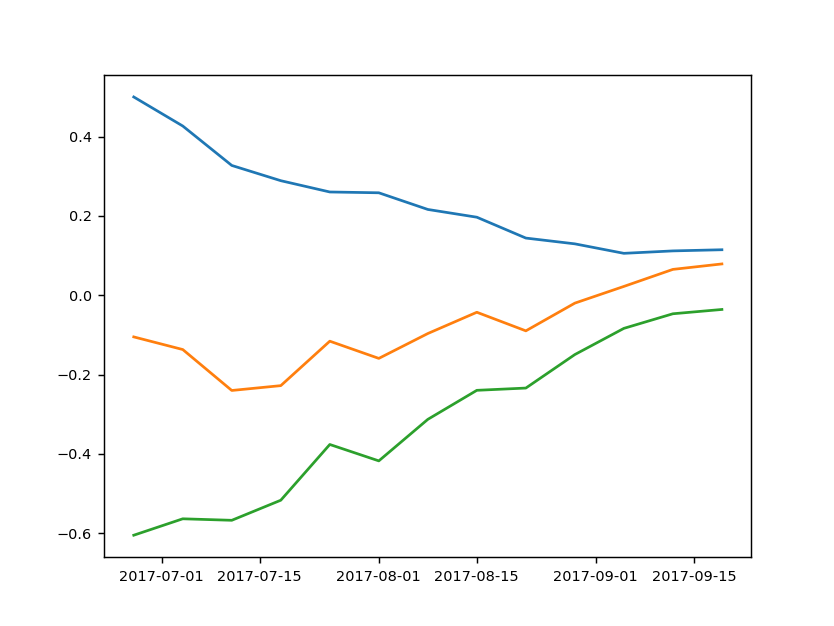

2501
239


In [22]:
plt.figure()
plt.plot(T30['ER_est'].resample('W-Tue').mean()*mult['fco2']*1)
plt.plot(T30['NEE_est'].resample('W-Tue').mean()*mult['fco2']*1)
plt.plot(T30['NEE_est'].resample('W-Tue').mean()*mult['fco2']*1-T30['ER_est'].resample('W-Tue').mean()*mult['fco2']*1)
print(T30['fco2'].count())
print(T30.loc[T30['Daytime']==0,'fco2'].count())

# print(T30[['fch4','Collapse']].count())

<IPython.core.display.Javascript object>


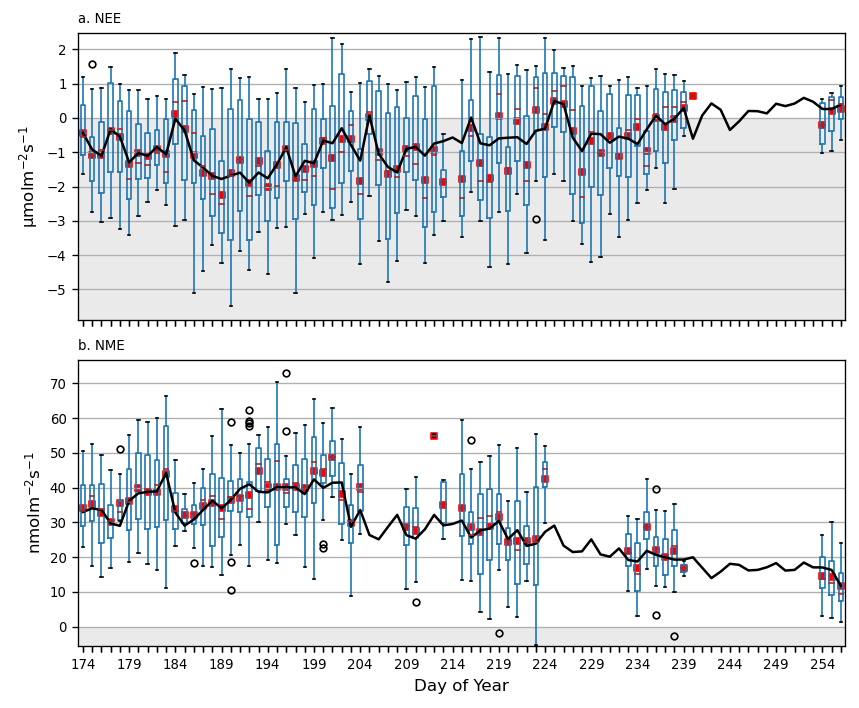

          index
Week           
1.0  2017-06-23
2.0  2017-06-30
3.0  2017-07-07
4.0  2017-07-14
5.0  2017-07-21
6.0  2017-07-28
7.0  2017-08-04
8.0  2017-08-11
9.0  2017-08-18
10.0 2017-08-25
11.0 2017-09-01
12.0 2017-09-08
Index(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0',
       '11.0', '12.0'],
      dtype='object', name='Week')


In [201]:

T30['Hour']=T30.index.hour-3
T30.loc[T30['Hour']<0,'Hour']+=24

cm = 1/2.54  # centimeters in inches
# plt.subplots(figsize=(15*cm, 5*cm))

fig,ax = plt.subplots(2,1,sharex=True,figsize=(18.2*cm, 15*cm))
medianprops = dict(linestyle='-', linewidth=1, color='k')
T30['ch4_flux_scaled']=T30['ch4_flux']*1e3

Agg = 'DOY'

T30['Week'] = np.floor(((T30.index.dayofyear - T30.index.dayofyear[0])/7))+1
# T30['Week_Raw'] = ((T30.index.dayofyear - T30.index.dayofyear[0])/7)

T30['DOW'] = T30.index.dayofweek
T30['datetime']=T30.index
# Wk = T30['Week'].resample('Week')
First = T30[['Week']].reset_index().groupby('Week').first()
Last = T30[['Week']].reset_index().groupby('Week').last()

print(First)
print(First.index.astype(str))
Xlbls = ('Week '+First.index.astype(int).astype(str)+'\n'+First['index'].dt.dayofyear.astype(str)+ '-'+Last['index'].dt.dayofyear.astype(str))
# Idx = T30['Week].

flierprops = dict(markersize=4)

bp0=T30[['co2_flux',Agg]].boxplot(by=Agg,ax=ax[0],medianprops = medianprops,flierprops=flierprops, return_type='dict')
bp1=T30[['ch4_flux_scaled',Agg]].boxplot(by=Agg,ax=ax[1],medianprops = medianprops,flierprops=flierprops, return_type='dict')



[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Week = T30.groupby(Agg).mean()
WeekC = T30.groupby(Agg).count()
XT = ax[0].get_xticks()[0:Week.shape[0]]
a1=((Week['NEE'].max()-Week['NEE'].min())/mult['fco2'])
b1=((Week['NME'].max()-Week['NME'].min())/mult['fch4'])
ax[0].scatter(XT,Week['co2_flux'], color='r',s=10,marker='s')
ax[1].scatter(XT,Week['ch4_flux']*1e3, color='r',s=10,marker='s')
# ax02 = ax[0].twinx()
# ax12 = ax[1].twinx()
# ax02.plot(XT,WeekC['co2_flux']/WeekC['Hour'],color='k',linestyle=':')
# ax12.plot(XT,WeekC['ch4_flux']/WeekC['Hour'],color='k',linestyle=':')

# ax[0].set_zorder(ax02.get_zorder()+1)
ax[0].patch.set_visible(False)
# ax[1].set_zorder(ax12.get_zorder()+1)
ax[1].patch.set_visible(False)
# ax02.set_ylim(0,1)
# ax12.set_ylim(0,1)
# ax02.set_ylabel('Data Coverage %')
# ax12.set_ylabel('Data Coverage %')

# print(Temp['ch4_flux'].count()/Temp['NME'].count())
ax[0].plot(XT,Week['NEE'],color='k')
# ax[0].plot(XT,Week['ER']/mult['fco2'],color='k',linestyle='-.')
# ax[0].plot(XT,-Week['GPP']/mult['fco2'],color='k',linestyle=':')
ax[1].plot(XT,Week['NME'],color='k')

ax[0].grid(axis='x')
ax[1].grid(axis='x')
yl1 = [T30['co2_flux'].min()+T30['co2_flux'].min()*.075,T30['co2_flux'].max()+T30['co2_flux'].max()*.05]#ax[0].get_ylim()
ax[0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)
yl2 = [T30['ch4_flux'].min()*1e3+T30['ch4_flux'].min()*1e3*.075,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.05]#ax[1].get_ylim()
ax[1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
# ax2 = ax[1].twinx()
# ax2.plot(Week['Table_1'])

# ax[1].set_ylim(yl2[0],yl2[1])
ax[0].set_title('')
ax[1].set_title('')

ax[0].set_title('a. NEE',loc='left')
ax[1].set_title('b. NME',loc='left')
ax[0].set_xlabel('')
ax[1].set_xlabel('Day of Year')
ax[0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1].set_ylabel('$nmol m^{-2} s^{-1}$')

ax[0].set_ylim(yl1[0],yl1[1])
ax[1].set_ylim(yl2[0],yl2[1])


if Agg == 'Week':
    ax[1].set_xticklabels(Xlbls,rotation =45)
# ax[1].set_xticsk
# print(XT)
else:
    for i,label in enumerate(ax[1].xaxis.get_ticklabels()):
        if math.remainder(i,5) != 0:
            label.set_visible(False)
        
plt.suptitle('')
plt.tight_layout()
plt.savefig('G:\\My Drive\\FI_Manuscript/Fig4_Revised.jpg',dpi = 600)


<IPython.core.display.Javascript object>


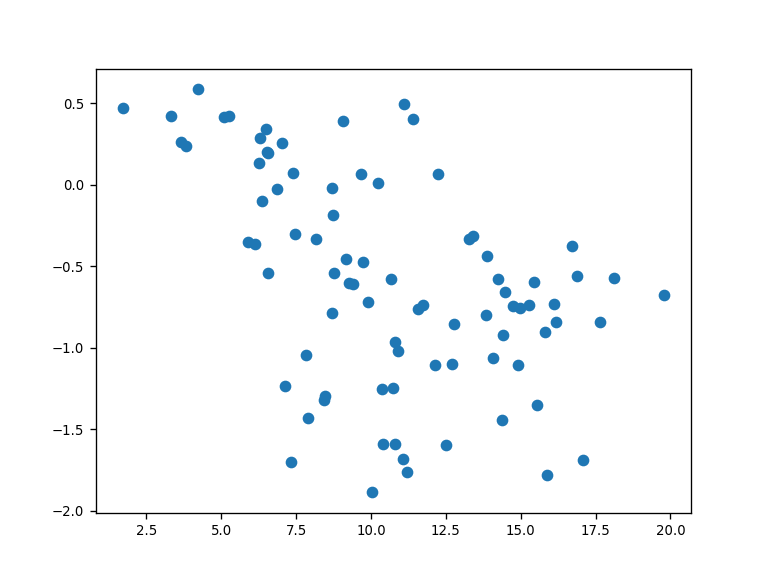

In [202]:

plt.figure()
plt.scatter(Week['AirTC_Avg'],Week['NEE'])

<IPython.core.display.Javascript object>


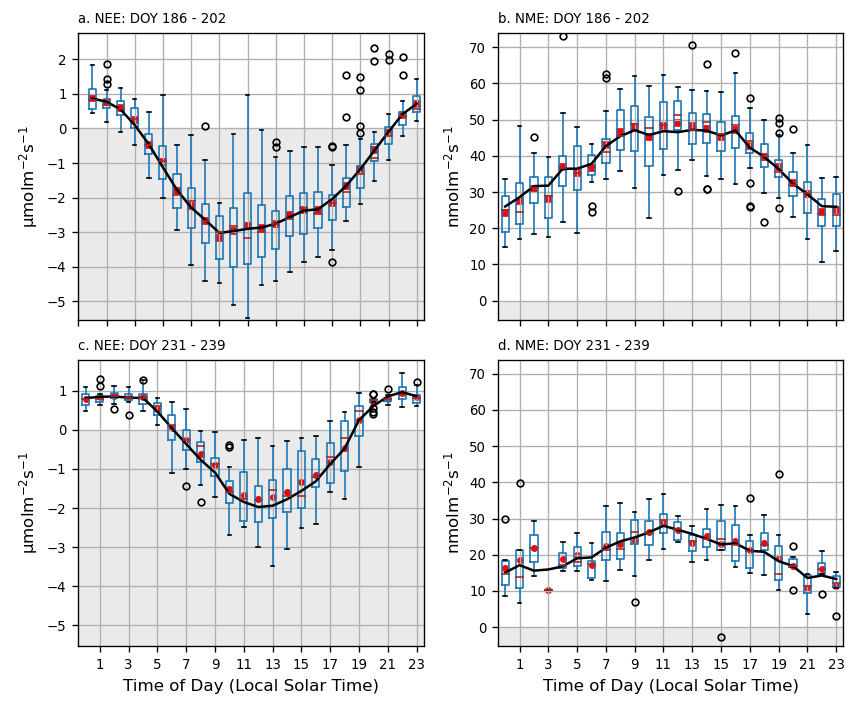

18
19.543764705882353
Model
mean:  -1.3436850522822725 38.418021877584096
max:  0.8667291574905017 47.194021902197036
min:  -3.0184665930329295 25.931273353231035
Obs
mean:  -1.3386375575931917 38.310827832283174
max:  0.886284101811012 49.162590507575075
min:  -3.1595512543701054 24.339521024412125
Peak
[9]
[13]
Min
[0]
[23]
9
Model
mean:  -0.3130459228175548 20.19509226505762
max:  0.9615511859493849 27.99650701839096
min:  -1.974608152526649 13.304695286630725
Obs
mean:  -0.23636071120988164 20.32787665863268
max:  0.9499816415266289 29.09821761891306
min:  -1.7670561641855558 10.130780332320516
Peak
[12]
[11]
Min
[22]
[23]
12
7.444444444444443


In [203]:

fig,ax = plt.subplots(2,2,sharex=True,figsize=(18.2*cm, 15*cm))
medianprops = dict(linestyle='-', linewidth=1, color='k')
T30['ch4_flux_scaled']=T30['ch4_flux']*1e3

flierprops = dict(markersize=4)
Temp = T30.loc[((T30.DOY>=186) & (T30.DOY<=202))]
# Temp = T30.loc[T30.Month==7]
bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[0,0],medianprops = medianprops,flierprops=flierprops, return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[0,1],medianprops = medianprops,flierprops=flierprops, return_type='dict')


[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Hour = Temp.groupby('Hour').mean()

a1=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b1=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])

print(Hour.loc[Hour['NEE']<0].count()['NEE'])
print(Hour.PPFD_Avg.min())

print('Model')
print('mean: ',Hour['NEE'].mean(),Hour['NME'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max(),Hour['NME'].max())#/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min(),Hour['NME'].min())#/mult['fco2']*1e3)
print('Obs')
print('mean: ',Hour['fco2'].mean(),Hour['fch4'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['fco2'].max(),Hour['fch4'].max())#/mult['fco2']*1e3)
print('min: ',Hour['fco2'].min(),Hour['fch4'].min())#/mult['fco2']*1e3)
print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)
print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)

ax[0,0].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10,marker='s')
ax[0,1].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10,marker='s')
ax[0,0].plot(Hour.index+1,Hour['NEE'],color='k')
ax[0,1].plot(Hour.index+1,Hour['NME'],color='k')

yl1 = [T30['co2_flux'].min()+T30['co2_flux'].min()*.01,T30['co2_flux'].max()+T30['co2_flux'].max()*.01]#ax[0,0].get_ylim()
ax[0,0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)
ax[0,0].set_ylim(yl1[0],2.75)#yl1[1])
yl2 = [T30['ch4_flux'].min()*1e3+T30['ch4_flux'].min()*1e3*.01,T30['ch4_flux'].max()*1e3+T30['ch4_flux'].max()*1e3*.01]#ax[0,1].get_ylim()
ax[0,1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
ax[0,1].set_ylim(yl2[0],yl2[1])
ax[0,0].set_title('')
ax[0,1].set_title('')
ax[0,0].set_title('a. NEE: DOY 186 - 202',loc='left')
ax[0,1].set_title('b. NME: DOY 186 - 202',loc='left')
ax[0,0].set_xlabel('')
ax[0,1].set_xlabel('')
ax[0,0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[0,1].set_ylabel('$nmol m^{-2} s^{-1}$')


# Temp = T30.loc[((T30.DOY>=230) & (T30.DOY<=243))]
Temp = T30.loc[((T30.DOY>=231) & (T30.DOY<=239))]
print(Temp.resample('D').mean()['NEE'].count())

bp0=Temp[['co2_flux','Hour']].boxplot(by='Hour',ax=ax[1,0],medianprops = medianprops,flierprops=flierprops,return_type='dict')
bp1=Temp[['ch4_flux_scaled','Hour']].boxplot(by='Hour',ax=ax[1,1],medianprops = medianprops,flierprops=flierprops,return_type='dict')
[[item.set_color('#a02c2c') for item in bp0[key]['medians']] for key in bp0.keys()]
[[item.set_color('#a02c2c') for item in bp1[key]['medians']] for key in bp1.keys()]
Hour = Temp.groupby('Hour').mean()
a2=((Hour['NEE'].max()-Hour['NEE'].min())/mult['fco2'])
b2=((Hour['NME'].max()-Hour['NME'].min())/mult['fch4'])

print('Model')
print('mean: ',Hour['NEE'].mean(),Hour['NME'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['NEE'].max(),Hour['NME'].max())#/mult['fco2']*1e3)
print('min: ',Hour['NEE'].min(),Hour['NME'].min())#/mult['fco2']*1e3)
print('Obs')
print('mean: ',Hour['fco2'].mean(),Hour['fch4'].mean())#/mult['fco2']*1e3)
print('max: ',Hour['fco2'].max(),Hour['fch4'].max())#/mult['fco2']*1e3)
print('min: ',Hour['fco2'].min(),Hour['fch4'].min())#/mult['fco2']*1e3)
print('Peak')
print(Hour.loc[Hour['NEE']==Hour['NEE'].min()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].max()].index.values)
print('Min')
print(Hour.loc[Hour['NEE']==Hour['NEE'].max()].index.values)
print(Hour.loc[Hour['NME']==Hour['NME'].min()].index.values)
print(Hour.loc[Hour['NEE']>0].count()['NEE'])

ax[1,0].scatter(Hour.index+1,Hour['co2_flux'], color='r',s=10)
ax[1,1].scatter(Hour.index+1,Hour['ch4_flux']*1e3, color='r',s=10)
ax[1,0].plot(Hour.index+1,Hour['NEE'],color='k')
ax[1,1].plot(Hour.index+1,Hour['NME'],color='k')
# # yl = ax[1,0].get_ylim()
ax[1,0].axhspan(yl1[0],0, facecolor='0.2', alpha=0.1)

ax[1,0].set_ylim(yl1[0])#yl1[1])
# yl = ax[1,1].get_ylim()
ax[1,1].axhspan(yl2[0],0, facecolor='0.2', alpha=0.1)
ax[1,1].set_ylim(yl2[0],yl2[1])
ax[1,0].set_title('')
ax[1,1].set_title('')
ax[1,0].set_title('c. NEE: DOY 231 - 239',loc='left')
ax[1,1].set_title('d. NME: DOY 231 - 239',loc='left')
ax[1,0].set_xlabel('')
ax[1,1].set_xlabel('Time of Day (Local Solar Time)')
ax[1,0].set_xlabel('Time of Day (Local Solar Time)')
ax[1,0].set_ylabel('${\mu}mol m^{-2} s^{-1}$')
ax[1,1].set_ylabel('$nmol m^{-2} s^{-1}$')
ax[0,0].set_xticks([x for x in range(0,25,2)])
ax[1,1].set_xticklabels([x-1 for x in range(0,25,2)])


plt.suptitle('')
plt.tight_layout()

plt.savefig('G:\\My Drive\\FI_Manuscript/Fig5_Revised.jpg',dpi = 600)
# # print(T30[['Time','Hour']][0:100].values)
# print(T30.loc[((T30['DOY']>187)&(T30['DOY']<202)),'PPFD_Avg'].resample('D').min().mean())
# print(T30.loc[((T30['DOY']>229)&(T30['DOY']<244)),'PPFD_Avg'].resample('D').min().mean())
# print(T30.loc[((T30['DOY']>187)&(T30['DOY']<202))].groupby('Daytime').count()['DOY']/(14*2))
# print(T30.loc[((T30['DOY']>229)&(T30['DOY']<244))].groupby('Daytime').count()['DOY']/(14*2))
print((1-Hour.Daytime.mean())*24)


<IPython.core.display.Javascript object>


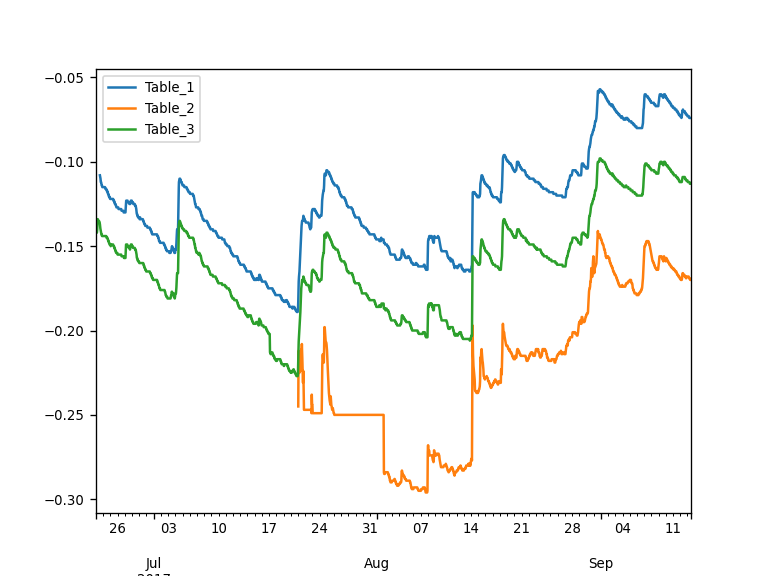

0.10863212237093749
0.03569097839898342


In [204]:
fig,ax=plt.subplots()# print((1-Week['Daytime'])*24)
T30[['Table_1','Table_2','Table_3']].plot(ax=ax)
print((T30['Table_1']-T30['Table_2']).mean())
print((T30['Table_1']-T30['Table_3']).mean())

<IPython.core.display.Javascript object>


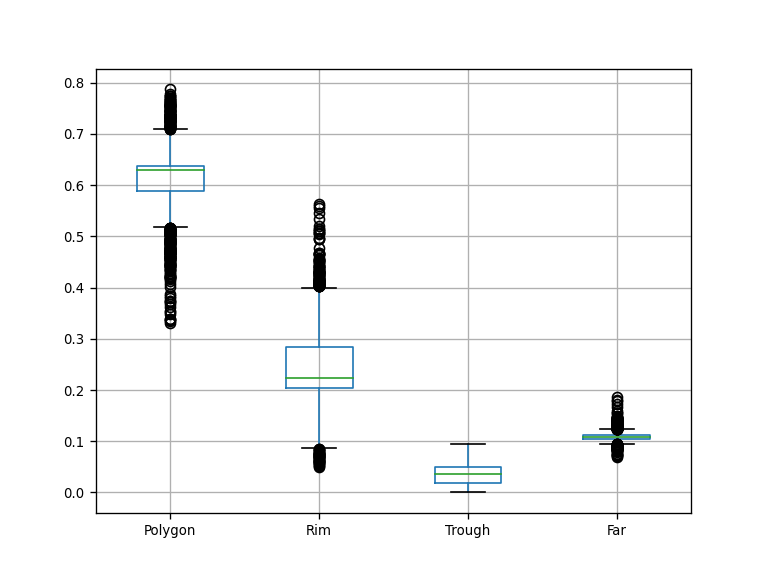

In [205]:
plt.figure()
# plt.plot()
T30['Trough'] = T30['Collapse']+0
T30['Far'] = T30['FarField']+0
T30[['Polygon','Rim','Trough','Far']].boxplot()

Unnamed: 0         83
file_records       83
used_records       83
Tau                83
qc_Tau             83
                   ..
ch4_flux_scaled    55
Week               83
DOW                83
Trough             83
Far                83
Length: 568, dtype: int64
Unnamed: 0         79
file_records       79
used_records       79
Tau                79
qc_Tau             79
                   ..
ch4_flux_scaled    51
Week               79
DOW                79
Trough             79
Far                79
Length: 568, dtype: int64


<IPython.core.display.Javascript object>


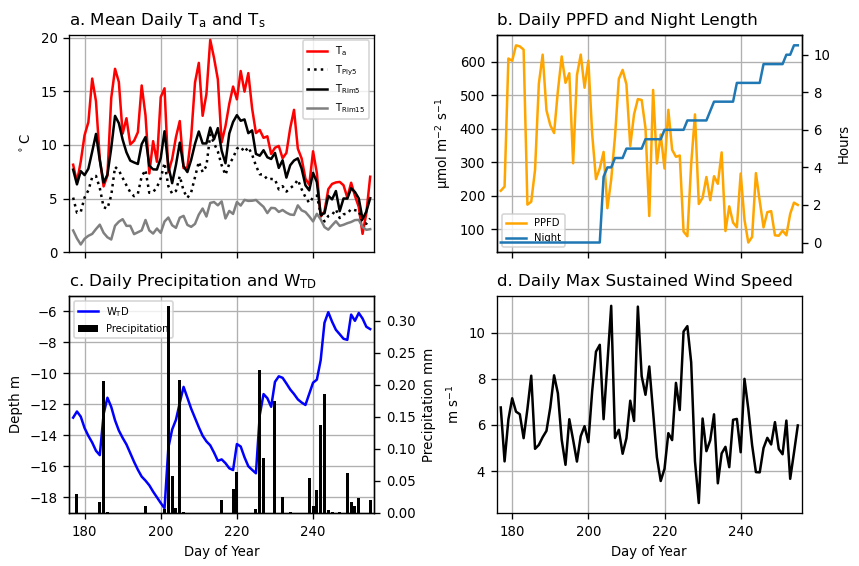

In [206]:
# fig = plt.figure(figsize=(6.5,7))

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


Daily = T30.groupby('DOY').mean()
Daily['Rain_mm_Tot'] = T30['Rain_mm_Tot'].resample('D').mean().values
Daily['Daytime'] = ((T30['Daytime']-1)**2).resample('D').sum().values/2
Daily['wind_speed'] = T30['wind_speed'].resample('D').max().values

print(Daily.count())
Daily = Daily[3:-1]
print(Daily.count())

fig,ax = plt.subplots(2,2,figsize=(18.2*cm,12*cm),sharex=True)

ax[1,0].set_title('c. Daily Precipitation and W$_{TD}$',loc='left')
ax[1,1].set_title('d. Daily Max Sustained Wind Speed',loc='left')
# ax[2,0].set_title('e.',loc='left')
ax[0,1].set_title('b. Daily PPFD and Night Length',loc='left')
ax[0,0].set_title('a. Mean Daily T$_{a}$ and T$_{s}$',loc='left')

ax[1,0].grid()
ax[1,1].grid()
ax[0,1].grid()
ax[0,0].grid()

ax[0,0].plot(Daily.index,Daily['AirTC_Avg'],color='r',label='T$_a$')
ax[0,0].set_ylabel('$^\circ$C')
ax[0,0].plot(Daily.index,Daily['Temp_5_1'],color='k',label='T$_{Ply5}$',linestyle=':')
ax[0,0].plot(Daily.index,Daily['Temp_5_2'],color='k',label='T$_{Rim5}$')
ax[0,0].plot(Daily.index,Daily['Temp_15_1'],color='grey',label='T$_{Rim15}$')
ax[0,0].legend()


ax[1,1].plot(Daily['wind_speed'],color='k',label='Sustained')


ax[1,1].set_ylabel('m s$^{-1}$')
ax[0,0].set_ylim(0,20.2)

ax[0,1].plot(Daily['PPFD_Avg'],color='orange',label='PPFD')
ax[0,1].set_ylabel('$\mu$mol m$^{-2}$ s$^{-1}$')
ax2 = ax[0,1].twinx()
ax[0,1].plot(Daily['Daytime']*np.nan,label='Night')
ax2.plot(Daily['Daytime'])
ax2.set_ylabel('Hours')
ax[0,1].legend(loc=3)

ax[1,0].plot(Daily['Table_1']*100,color='blue',label='W${_TD}$')
ax[1,0].set_ylabel('Depth m')
ax[1,0].set_ylim(-19,-5)

ax2=ax[1,0].twinx()
ax2.bar(Daily.index,Daily['Rain_mm_Tot'],color='k')
ax[1,0].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,color='k',label='Precipitation')
ax2.set_ylabel('Precipitation mm')
ax[1,0].legend()
ax[1,0].set_xlabel('Day of Year')

ax[0,1].set_xlim(Daily.index[0]-1,Daily.index[-1]+1)
ax[1,0].set_xlim(Daily.index[0]-1,Daily.index[-1]+1)
plt.tight_layout()
ax[1,1].set_xlabel('Day of Year')

plt.savefig('Conditions.jpg',dpi = 600)

<IPython.core.display.Javascript object>


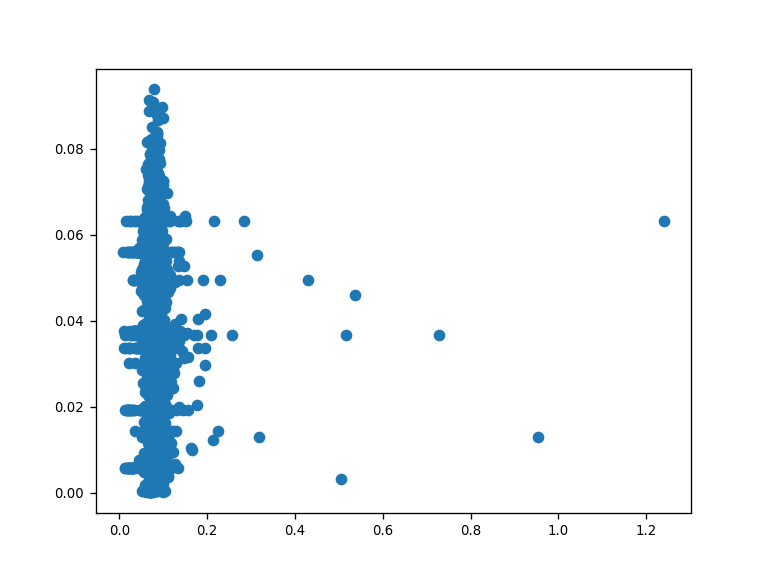

             Ratio  Collapse
Ratio     1.000000  0.000071
Collapse  0.000071  1.000000


In [207]:
# print(T30.loc[T30['Daytime']<1,'DOY'])
plt.figure()
plt.scatter(T30['Ratio'],T30['Collapse'])
print(T30[['Ratio','Collapse']].corr()**2)

In [208]:
# Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
# Site = 'FishIsland_Paper/'
# File_Name = 'AllData.csv'
# # Site = 'FishIsland_BL_Flaw/'
# # File_Name = 'Data_Footprints_2021-09-24_2000mx2m.csv'

# # Site = 'FishIsland/'
# # File_Name = 'Data_Footprints_2021-09-26_2000mx2m.csv'
# # Site = 'FishIsland _BLupdate/'
# # File_Name = 'Data_Footprints_2021-09-26_2000mx2m.csv'
# Path = Path+Site
# AllRes = RecRead(Path = Path) 


Path = 'C:\\Users\\wesle\\NetworkAnalysis\\'
# Site = 'FishIsland_Paper/'
# Site = 'FishIsland_Keep/'
# Site = 'FishIsland_BL_Flaw/'
# File_Name = 'Data_Footprints_2021-09-24_2000mx2m.csv'
Site = 'FishIsland/'
# Site = 'FishIsland_Arctic_Sci/'
File_Name = 'Data_Footprints_2022-02-16_2000mx2m.csv'
Path = Path+Site
AllRes = RecRead(Path = Path) 

for i,F in enumerate(['fco2','fch4']):
# for i,F in enumerate(['fch4']):
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
#     print(Records['Remove'])
    MBE = []
    MBEs = []
    RMSE = []
    RMSEs = []
    r2 = []
    SDev = []

    for I in Records.index:
    #     print(I)
        
        y = np.load(Path+F+'_Yhat_'+I+'.npy')#.mean(axis=0)
        x = np.load(Path+F+'_Ytrue_'+I+'.npy')#.mean(axis=0)
        K = y.shape[0]
        df = pd.DataFrame(data={'target':y.flatten(),'y':x.flatten()}).dropna()

        mbe = (np.nansum((x-y),axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))
        MBEs.append(mbe.std())

        rmse = (np.nansum((x-y)**2,axis=1)/((x-y).shape[1]-np.isnan((x-y)).sum(axis=1)))**.5
        RMSEs.append(rmse.std())

        MBE.append((df['y']-df['target']).sum()/df['y'].count())
        SDev.append(np.abs(df['y']-df['target']).sum()/df['y'].count()*2**.5)
        RMSE.append(metrics.mean_squared_error(df['y'],df['target'])**.5)
        r2.append(metrics.r2_score(df['y'],df['target']))

    RMSEs=np.array(RMSEs)
    MBEs=np.array(MBEs)

    df = pd.DataFrame(index = Records.index,data = {'RMSE':RMSE,'SE':RMSEs/(K**.5),'MBE':MBE,'MBESE':MBEs/(K**.5),'R2':r2})
    df['Diff']=df['RMSE'].diff()
    Xlbls = []
    for v in Records.Remove:
        try:
            Xlbls.append(NameDict[v])
        except:
            Xlbls.append('N/A')
            pass
    df = df.iloc[::-1]
    df['Factor']=Xlbls[::-1]
    
    Mn = (df.loc[df['RMSE']==df['RMSE'].min()])
    Mn = (df.loc[df['R2']==df['R2'].max()])
    df['PCT'] = Mn['RMSE'].values[0]/df['RMSE']
    
#     print(Mn[['Factor','R2','RMSE','Diff','MBE']].round(3))
    print(df[['Factor','R2','RMSE','SE','Diff','MBE','PCT']].round(4)[::-1])
    



      Factor      R2    RMSE      SE    Diff     MBE     PCT
21_75    N/A  0.9471  0.3432  0.0024     NaN -0.0045  1.0000
8_75     N/A  0.9312  0.3914  0.0022  0.0482  0.0028  0.8769
      Factor      R2    RMSE      SE    Diff     MBE     PCT
21_43    N/A  0.7425  6.3884  0.0492     NaN  0.0248  1.0000
8_43     N/A  0.7298  6.5439  0.0466  0.1554  0.0432  0.9762


                                                                                                                                                                                          Model  \
21_75  AirTC_Avg+VPD+u*+wind_speed+air_pressure+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+VWC_1+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+Collapse+Polygon+Rim+Daytime   
8_75                                                                                                                 VPD+wind_speed+PPFD_Avg+Active_Layer_1+Temp_5_1+Temp_5_2+Temp_15_2+Daytime   

       Size  Nodes       MSE      RMSE        SE        r2  Performance   K  \
21_75    21     75  0.093951  0.306515  0.001947  0.957826            0  30   
8_75      8     75  0.141006  0.375508  0.001697  0.936704            0  30   

         Thresh  Remove       RSE  
21_75  0.095899     NaN  0.044130  
8_75   0.142703     NaN  0.041197  
                                                                    

<IPython.core.display.Javascript object>


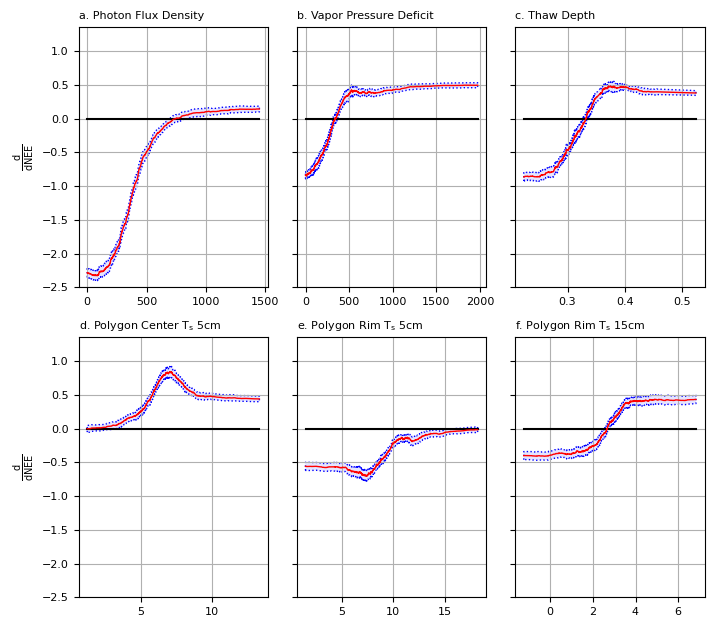

PPFD_Avg -2.327474296092987
X    743.800000
Y      0.000559
dtype: float64
Net Influence
-3399.72400405289

VPD -0.8481245458126068
X    336.935364
Y      0.000093
dtype: float64
Net Influence
-774.8577816655238

Active_Layer_1 -0.8645156423250834
X    0.331978
Y   -0.000836
dtype: float64
Net Influence
-340.76784270275374

Temp_5_1 -0.004175505600869656
X    1.254000
Y   -0.002506
dtype: float64
Net Influence
1147.468627768258

Temp_5_2 -0.704037677248319
X    18.060000
Y    -0.017381
dtype: float64
Net Influence
-1003.4479672274863

Temp_15_2 -0.41022945468624433
X    2.673000
Y   -0.000092
dtype: float64
Net Influence
169.4127660868379

                                                                                                                                                                                          Model  \
21_43  AirTC_Avg+VPD+u*+wind_speed+air_pressure+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+VWC_1+Active_Layer_1+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp

<IPython.core.display.Javascript object>


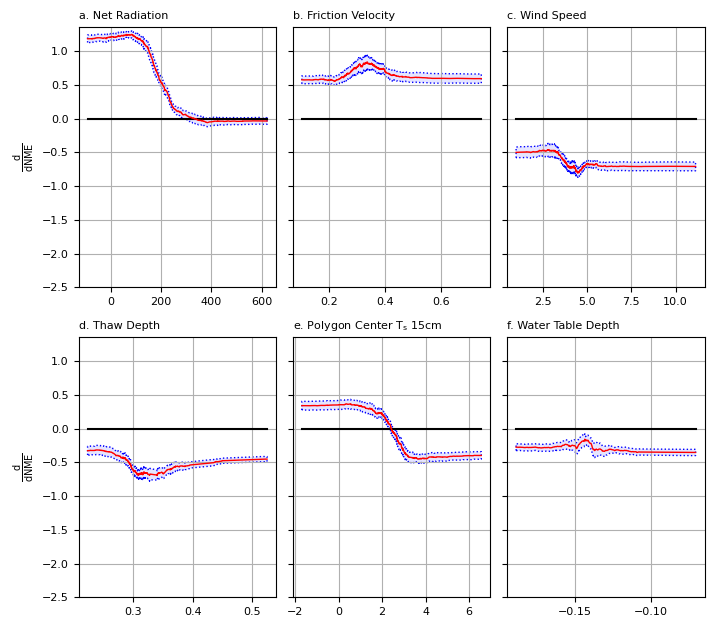

NR_Wm2_Avg -0.0599636805554231
X    332.900000
Y     -0.003232
dtype: float64
Net Influence
1037.243694374524

u* 0.553616714477539
X    0.220594
Y    0.553617
dtype: float64
Net Influence
962.1003919405241

wind_speed -0.8069452047348022
X    2.803100
Y   -0.464235
dtype: float64
Net Influence
-897.8512745482226

Active_Layer_1 -0.6961476892232895
X    0.238201
Y   -0.317084
dtype: float64
Net Influence
-720.0905880670995

Temp_15_1 -0.452557339767615
X    2.417000
Y   -0.001212
dtype: float64
Net Influence
-100.57846022017759

Table_1 -0.35524286280075706
X   -0.143500
Y   -0.158878
dtype: float64
Net Influence
-411.27906578405134



In [27]:

co2_Model_Index = '8_75'
ch4_Model_Index = '8_43'


cm = 1/2.54

Fco2_Vars = ['PPFD_Avg','VPD','Active_Layer_1','Temp_5_1','Temp_5_2','Temp_15_2']#,'VWC_1']
Fch4_Vars =['NR_Wm2_Avg','u*','wind_speed','Active_Layer_1','Temp_15_1','Table_1']#]

# Fco2_Vars =['PPFD_Avg','VPD','Active_Layer_1','Temp_5_1','Temp_15_2','wind_speed']
# Fch4_Vars =['u*','wind_speed','NR_Wm2_Avg','Active_Layer_1','Temp_15_1','Temp_5_2']

Xlbl={'co2':[r'${\mu}mol\ m^{-2}\ s^{-1}$','Pa','m',r'$^{\circ}$C',r'$^{\circ}$C',r'$^{\circ}$C'],
     'ch4':[r'$W m^{-2}\ s^{-1}$','m',r'$^{\circ}$C',r'$m s^{-1}$',r'$m s^{-1}$','%']}

Fname={'fco2':'Fig6_Revised.jpg',
      'fch4':'Fig9_Revised.jpg'}

for i,F in enumerate(['fco2','fch4']):
    RSM = 0
    Results = AllRes[F]['Results']
    Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
    Records = AllRes[F]['Records']
    print(Records)
    
    Model_Index = co2_Model_Index
    if F == 'fch4':
        Model_Index = ch4_Model_Index
    elif F == 'ER':
        Model_Index = ER_Model_Index
    if Model_Index == None:
        Best = Records.loc[Records['Size']==Records['Size'].min()]
    else:
        Best = Records.loc[Records.index==Model_Index]    
    print(Best)
    Size = Best.Size.values[0]
    Nodes = Best.Nodes.values[0]
    # N = Records.Size.max()
    Records['RMSE']=Records['MSE']**.5
    Records['RSE']=Records['SE']**.5
    Best_U = 'RC_Sum: '+Best.index.values[0]
    
    Derivatives = np.load(Path+F+'_Derivatives_'+Best.index.values[0]+'.npy')
    Mean = Derivatives.mean(axis=0)
    Std = Derivatives.std(axis=0)
    X = np.load(Path+F+'_X_'+str(Size)+'.npy')

    Deriv_Labels= DerivKeys(Results,Best_U)
    SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

    SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
    print(SubSet[['Factors',Best_U,'Cumsum']].round(4).sort_values(by='Cumsum').reset_index())
    print(SubSet['Factors'].values)
    
#     fig,ax=plt.subplots(figsize=(4.5,4.5))
#     ax.barh(SubSet.index,SubSet[Best_U]*100,#xerr=SubSet[Best_SE]*100,
#              height=.4,color='g',edgecolor='k')
#     ax.set_yticks(SubSet.index)
#     ax.set_yticklabels([NameDict[v] for v in SubSet['Factors'].values])

#     ax.set_xlabel('Relative Feature Importance %')
#     ax.set_title('Model Weights : '+F)
#     ax.grid()
#     plt.tight_layout()
#     plt.savefig('PAD_'+F+'_PrunedFactors.png')
    
    Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
    if F == 'fco2':
        Vars = Fco2_Vars
        C = 3
        Xsize = 18.2
        Ysize = 16
    else:
        Vars = Fch4_Vars
        C = 3
        Xsize = 18.2
        Ysize = 16
    
    import math
    from string import ascii_lowercase
    df = pd.DataFrame(data={'Vars':Vars})
    rsmp = 50
    R=math.ceil(len(Vars)/C)
    
    fig = plt.figure(figsize=(Xsize*cm,Ysize*cm))
    gs = fig.add_gridspec(R,C)
    r,c=0,0
    for j,Var in enumerate(Vars):
        if c == C:
            c = 0
            r+=1
        i=Deriv_Labels[Var]
        if c == 0:
            ax1 = fig.add_subplot(gs[r, c])#,sharex=ax2)
            ax1.set_ylabel(r'$\frac{d}{d'+AbbrevDict[F]+'}$')
#             ax2 = ax1.twinx()
#             plt.setp(ax2.get_yticklabels(), visible=False)
        elif c == C-1:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
#             ax2 = ax1.twinx()
#             ax2.set_ylabel('Training Samples')
            plt.setp(ax1.get_yticklabels(), visible=False)
        else:
            ax1 = fig.add_subplot(gs[r, c],sharey=ax1)#,sharex=ax2)
#             ax2 = ax1.twinx()
            plt.setp(ax1.get_yticklabels(), visible=False)
#             plt.setp(ax2.get_yticklabels(), visible=False)
        p = Derivatives.shape[0]
        ax1.plot([X[:,i].min(),X[:,i].max()],[0,0],color='k')
        
        
        Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
        Temp=Temp.sort_values(by='X')
        ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=1)
#         ax2.hist(Temp['X'],facecolor=[.9,.9,.9],edgecolor='k')
        
        
        Temp1 = pd.DataFrame(data={'X':X[:,i],'Y':(Std[i]/(p**.5)*stats.t.ppf(.025,p))})#-m)*X[:,i].std()-X[:,i].mean()
        Temp1=Temp1.sort_values(by='X')

        ax1.fill_between(Temp['X'],
            (Temp['Y']-Temp1['Y']), 
            (Temp['Y']+Temp1['Y']),
            facecolor = [0,0,1,.1],
            edgecolor = 'b',
            linestyle=':',
            linewidth=1,
           )
        
#         ax1.set_zorder(ax2.get_zorder() + 1)
#         ax1.patch.set_visible(False)
# #         ax.set
        
        print(Var, Temp['Y'].min())
        print(Temp.loc[np.abs(Temp['Y'])==np.abs(Temp['Y']).min()].mean())
        print('Net Influence')
        print(Temp['Y'].sum())
        print()
        if F!='fco2':
#             ax1.set_ylim(-1.25,1.35)
            ax1.set_ylim(-2.5,1.35)
#             ax2.set_ylim(0,650)
#             ax1.set_xlabel(AbbrevDict[Var]+' '+Xlbl['ch4'][j])
        else:
            ax1.set_ylim(-2.5,1.35)
#             ax2.set_ylim(0,1400)
#             ax1.set_xlabel(AbbrevDict[Var]+' '+Xlbl['co2'][j])
        ax1.grid()
        ax1.set_title(ascii_lowercase[j]+'. '+NameDict[Var],loc='left')
        c+=1
    plt.tight_layout()
    plt.savefig('G:\\My Drive\\Misc_Stuff/FI_Manuscript/'+Fname[F],dpi=600)

<IPython.core.display.Javascript object>


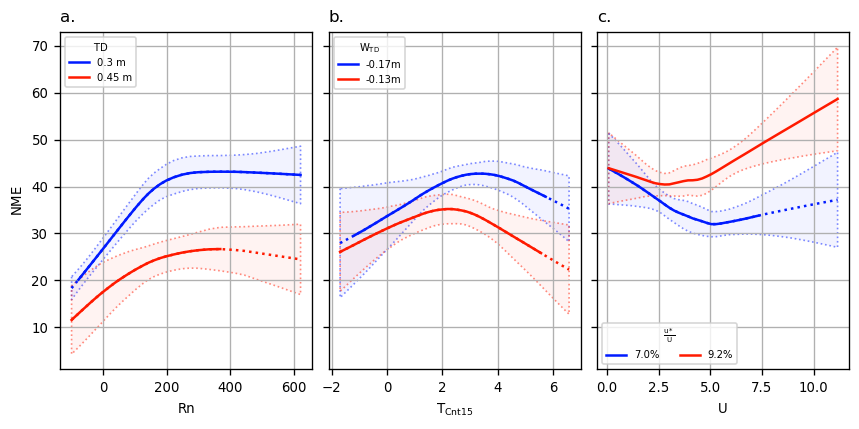

In [211]:
cm = 1/2.54
fig,ax = plt.subplots(1,3,figsize=(18.2*cm, 9.1*cm),sharey=True)
# IP = target.Model_Selection.split('+')
F = 'fch4'
N = 50

In [212]:
Plot1_ch4(ax[0])
Plot2_ch4(ax[1])
Plot3_ch4(ax[2])
plt.tight_layout()
plt.savefig('G:\\My Drive\\FI_Manuscript/Fig10_Revised.jpg',dpi=600)

['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim']
fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

1
fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

fch4 ['u*', 'wind_speed', 'NR_Wm2_Avg', 'Table_1', 'Active_Layer_1', 'Temp_15_1', 'Polygon', 'Rim'] C:\Users\wesle\NetworkAnalysis/FishIsland//fch4/8_43/


FloatProgress(value=0.0, description='Running:', max=30.0)

In [62]:
Adj = (T30[['Rim','Polygon','Collapse']].mean()/T30[['Rim','Polygon','Collapse']].mean().sum()).round(2)
print(Adj)
print(Adj-np.array([0.33,0.62,0.05]))

# 62.6% polygon centers, 32.8% ridges, and 4.5% troughs

Rim         0.27
Polygon     0.69
Collapse    0.04
dtype: float64
Rim        -0.06
Polygon     0.07
Collapse   -0.01
dtype: float64


In [63]:
def Plot1_ch4(ax):
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fch4.RST.Master.copy()
    target = fch4
    IP = target.Model_Selection.split('+')
    print(IP)
    for a in 'fch4','fco2':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['NR_Wm2_Avg']
    # Avars=['Collapse']
    A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
    Bvars=['Active_Layer_1']
    B = np.array([0.3,0.45])
    # B = np.array([0.33])
    C=[[],[],[],[]]
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,B)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp['Class']=Iv
        for cvar in Cvar:
            A = T30[[Avar,cvar]].dropna()
            Lr = scipy.stats.linregress(A[Avar],A[cvar])
            print(Lr)
            Cv=(Av*Lr[0]+1)+Lr[1]
            Temp[cvar]=Cv
        for dvar in Dvar:
            A = T30[[Bvar,dvar]].dropna()
            Lr = scipy.stats.linregress(A[Bvar],A[dvar])
            print(Lr)
            Dv=Bv*Lr[0]+Lr[1]
            Temp[dvar]=Dv
        for z,v in zip(Zero,Val):
            Temp[z]=v
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])

    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    if L == 0:
        L = 1
    print(L)
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        if v<= .33:
            TempA = Temp.loc[Temp[A]>-100]
            ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' m',color=[(L-(L-i))/L,.1,(L-i)/L])
        if v> .33:
            TempA = Temp.loc[Temp[A]<400]
            ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' m',color=[(L-(L-i))/L,.1,(L-i)/L])
        ax.fill_between(Temp[A],
            (Temp[Name]-Temp[Name+'_CI']), 
            (Temp[Name]+Temp[Name+'_CI']),
            facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
            edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
            linestyle=':',
            linewidth=1,
           )
        i +=1
    ax.set_ylabel(r'$NME\ {nmol\ m^{-2}\ s^{-1}$')
    ax.set_xlabel(AbbrevDict[Avars[0]])
    ax.grid()
    ax.legend(title='$TD$',loc='upper left')
    ax.set_title('a.',loc='left')
    # ax.tight_layout()
    # ax.savefig(F+'_Plot.png'

In [64]:
def Plot2_ch4(ax):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fch4.RST.Master.copy()
    T30['Active_Layer_1']=.3
    F = 'fch4'
    N = 50
    target = fch4
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fch4':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['Temp_15_1']
    # A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
    A = np.linspace(T30[Avars].min(),T30[Avars].max(),N)
    Bvars=['Active_Layer_1']
#     B = np.array([1,4])
    B = np.array([.3,.3])
    Balt = np.array([-0.17,-0.13])
    C=['Table_1',[],[],[]]
    # C=[[],[],[],[]]
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[[]],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,Balt)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp[Cvar]=Iv#Reg.predict(Bv.reshape(-1, 1))#Iv#Av*Iv##
        Temp['Class']=Iv#Bv
        for dvar in Dvar:
            A = T30[[Bvar,dvar]].dropna()
            Lr = scipy.stats.linregress(A[Bvar],A[dvar])
            print(Lr)
            Dv=Bv*Lr[0]+Lr[1]
            Temp[dvar]=Dv
        for z,v in zip(Zero,Val):
    #         print(z,v)
            if len(v)>1:
                i = 0
                for c in Temp['Class'].unique():
                    Temp.loc[Temp['Class']==c,z]=v[i]
    #                 print(Temp.loc[Temp['Class']==c,z])
                    i+=1
            else:
                Temp[z]=v[0]
    #     print(Temp)
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        if v == Balt[0]:
            TempA = Temp.loc[((Temp[A]>-1.226)&(Temp[A]<5.75))]
            ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'m',color=[(L-(L-i))/L,.1,(L-i)/L])
        else:
            TempA = Temp.loc[((Temp[A]>-1.7)&(Temp[A]<5.7))]
            ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'m',
                     color=[(L-(L-i))/L,.1,(L-i)/L])
#         ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],label=str(np.round(v,2)+' m')#,linestyle=':')
        ax.fill_between(Temp[A],
            (Temp[Name]-Temp[Name+'_CI']), 
            (Temp[Name]+Temp[Name+'_CI']),
            facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
            edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
            linestyle=':',
            linewidth=1,
           )
        i +=1
    ax.set_xlabel(AbbrevDict[Avars[0]])
    ax.legend(title=AbbrevDict[Cvar],loc='upper left')
    ax.grid()
    ax.set_title('b.',loc='left')

In [65]:
def Plot3_ch4(ax):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fch4.RST.Master.copy()
    # F = 'fch4'
    # N = 50
    target = fch4
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fch4':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['wind_speed']
    A = np.linspace(T30[Avars].min(),T30[Avars].max(),N)
    # A = np.array()
  
    
    Bvars=['Active_Layer_1']
    B = np.array([.3,.3])
    Balt = np.array([0.07,0.092])
    C=['u*',[],[],[]]
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,Balt)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp[Cvar]=Av*Iv
        Temp['Class']=Iv#Bv#+Bv
#         for cvar in Cvar:
#             A = T30[[Avar,cvar]].dropna()
#             Lr = scipy.stats.linregress(A[Avar],A[cvar])
#             Cv=Av*Lr[0]+Lr[1]
#             Temp[cvar]=Cv
        for z,v in zip(Zero,Val):
            if len(v)>1:
                i = 0
                for c in Temp['Class'].unique():
                    Temp.loc[Temp['Class']==c,z]=v[i]
                    i+=1
            else:
                Temp[z]=v[0]
        Temp['Active_Layer']=.3
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])

    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    
    
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        if v == Balt[0]:
            TempA = Temp.loc[(Temp[A]<7.5)]
            ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(TempA[A],TempA[Name],label=str(np.round(v*100,1))+'%',color=[(L-(L-i))/L,.1,(L-i)/L])
        else:
#             TempA = Temp.loc[((Temp[A]>0)&(Temp[A]<.52))]
#             ax.plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax.plot(Temp[A],Temp[Name],label=str(np.round(v*100,1))+'%',
                     color=[(L-(L-i))/L,.1,(L-i)/L])
            
        ax.fill_between(Temp[A],
            (Temp[Name]-Temp[Name+'_CI']), 
            (Temp[Name]+Temp[Name+'_CI']),
            facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
            edgecolor = [(L-(L-i))/L,.1,(L-i)/L,.5],
            linestyle=':',
            linewidth=1,
           )
        i +=1

    ax.legend(title=r'$\frac{u*}{U}$',ncol=2,loc='lower left')
    ax.set_xlabel(AbbrevDict[Avars[0]])
    ax.grid()
    ax.set_title('c.',loc='left')

In [ ]:
# print(Rec.loc[((Rec['Rim']<.3)&
#               (Rec['Rim']>.2)),['Rim','Test']])

print((37.97-33.99)/(0.292929-0.202020)*(1-0.292929))

# print
# print(T30.loc[T30['fch4'].isnull()==False,'Collapse'].median()- 0.04585634)
print(T30.loc[T30['fch4'].isnull()==False,'Collapse'].median()-T30.loc[T30['fch4'].isnull()==False,'Collapse'].max())
print(T30.loc[T30['fch4'].isnull()==False,'Collapse'].median()-T30.loc[T30['fch4'].isnull()==False,'Collapse'].min())
# print(T30.loc[T30['']])
T30.loc[T30['fch4'].isnull()==False,['Polygon','Rim','Collapse','FarField']].describe().round(3)#-\
# T30.loc[T30['fch4'].isnull()==False,['Polygon','Rim','Collapse','FarField']].describe().round(3)

In [ ]:
def Plot_Test_ch4(ax,s=0):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fch4.RST.Master.copy()
    # F = 'fch4'
    N = 100
    target = fch4
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fch4':
        IP.append(a)
    List = []
    Name = 'Test'
    
    Bvars=['Active_Layer_1']
    if s ==1:
        Avars=['Polygon']
        B = np.array([.305621,.305621])
        Balt = np.array([-0.060138497126602325,0.03368916104063099])
        C=[['Rim'],[],[],[]]
    else:
        Avars=['Rim']
        B = np.array([.305621])
        Balt = np.array([0])
        C=[['Polygon'],[],[],[]]
    A = np.linspace(T30[Avars].min(),T30[Avars].max(),N)
    A = np.linspace(0,1,N)
    

    
    D=[[],[],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]
    xxi = 0
    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,Balt)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
#         Temp[Dvar]=Bv*Iv
        Temp['Class']=Iv#Bv#+Bv
        for cvar in Cvar:
            A = T30[[Avar,cvar]].dropna()
            Lr = scipy.stats.linregress(A[Avar],A[cvar])
            Cv=Av*Lr[0]+Lr[1]
            Temp[cvar]=Cv+Iv
        for z,v in zip(Zero,Val):
            if len(v)>1:
                i = 0
                for c in Temp['Class'].unique():
                    Temp.loc[Temp['Class']==c,z]=v[i]
                    i+=1
            else:
                Temp[z]=v[0]
#         xxi += 0.02
        Temp['Active_Layer']=.3
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
#         if v == Balt[1]:
        TempA = Temp.loc[((Temp[A]>T30[Avar].min())&(Temp[A]<T30[Avar].max()))]
        ax.plot(Temp[A],Temp[Name],linestyle=':',color='k')#,color=[(L-(L-i))/L,.1,(L-i)/L])
        ax.plot(TempA[A],TempA[Name],label=str(np.round(v*100,1))+'%')#color=[(L-(L-i))/L,.1,(L-i)/L])
            
        ax.fill_between(Temp[A],
            (Temp[Name]-Temp[Name+'_CI']), 
            (Temp[Name]+Temp[Name+'_CI']),
            facecolor = [.1,.1,.1,.05],
            linestyle=':',
            linewidth=1,
           )
        i +=1

    if s ==1:
        ax.legend(title=r'$F_{Tro}$',ncol=2,loc='lower left')
#     else:
#         ax.legend(title=r'$F_{Cnt}$',ncol=2,loc='lower left')
    ax.set_xlabel(AbbrevDict[Avars[0]])
    ax.grid()
#     ax.set_title('c.',loc='left')
    ax.set_ylabel(r'$NME {nmol\ m^{-2}\ s^{-1}$')
    return(Rec)
    

In [ ]:
fig,ax=plt.subplots(2,1,figsize=(8.84*cm,17*cm))

In [ ]:
# fig,ax=plt.subplots(2,1,figsize=(8.84*cm,17*cm))

fig,ax=plt.subplots(figsize=(8.84*cm,8.84*cm))
Rec = Plot_Test_ch4(ax,s=0)
# ax.set_ylim(15,49)
# plt.savefig('G:\\My Drive\\FI_Manuscript/FigS3.jpg',dpi=600)

In [ ]:
print(T30.loc[T30['fco2'].isnull()==False,['FarField']].describe())#([0.25,.5,.75]))
# print(T30.loc[T30['fco2'].isnull()==False,'Rim'].quantile([0.25,.5,.75]))
# Test = T30[['Rim','Polygon']].dropna()
scipy.stats.linregress(Test['Polygon'],Test['Rim'])#.round(4)

# scipy.stats.linregress(Test['Rim'],Test['Polygon'])#.round(4)
# print((-0.9676849530461793)**2)

# LC_frac=np.array([.626,.328,.045])*(1-T30['FarField'].median())
# print(LC_frac)

In [ ]:
def Test2_ch4():
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fch4 = ResultMap(Path,'fch4',Test='N/A',Rule=ch4_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fch4.RST.Master.copy()
    N = 100
    target = fch4
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fch4':
        IP.append(a)
    List = []
    Name = 'Test'
    
#     low
#     T30['Polygon']=0.59106195
#     T30['Rim']=0.25390188
    
    
# #     high
#     T30['Polygon']=0.58658210
#     T30['Rim']=0.25786740
    
# #     mean
#     T30['Polygon']=0.58882202
#     T30['Rim']=0.25588464
    Temp = Mapper(T30,target,Name,Fill = False)
    print(Temp[Name].mean(),Temp[Name+'_CI'].mean())
#     List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    
    return(2)
    
# fig,ax=plt.subplots()
Rec = Test2_ch4()#ax)
# ax.set_ylim(29,44)
# plt.savefig('G:\\My Drive\\FI_Manuscript/FigS3.jpg',dpi=600)

# Mean
# 26.622295379638672 4.260855197906494

# Low
# 26.6591796875 4.246271133422852

# High
# 26.587671279907227 4.2764201164245605



In [ ]:
def Plot3_test():
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fco2.RST.Master.copy()
    T30['PPFD_Avg']=0
    T30['Daytime']=0
    F = 'fco2'
    N = 50
    target = fco2
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fco2':
        IP.append(a)
    List = []
    Name = 'Test'
    Temp = Mapper(T30,target,Name,Fill = False)
    print(Temp[Name].mean(),Temp[Name+'_CI'].mean())
    
    Temp = Temp[['ER',Name]].dropna()
    print(metrics.r2_score(Temp['ER'],Temp[Name]))
    print(metrics.r2_score(Temp['ER'],Temp[Name]))
    
#     return()
Plot3_test()

<IPython.core.display.Javascript object>


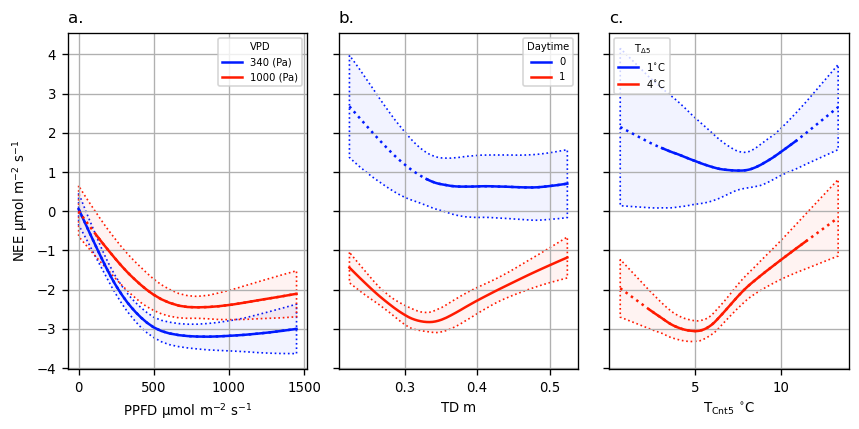

In [216]:
fig,ax = plt.subplots(1,3,figsize=(18.2*cm, 9.1*cm),sharey=True)

In [217]:
Plot1(ax)
Plot2(ax)
Plot3(ax)
plt.tight_layout()
plt.savefig('G:\\My Drive\\FI_Manuscript/Fig7_Revised.jpg',dpi=600)

['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime']
LinregressResult(slope=0.43050535487346825, intercept=-34.73166067602388, rvalue=0.980928476873282, pvalue=0.0, stderr=0.001356422729030322)
fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime']
LinregressResult(slope=406.2559363393052, intercept=3.512213225371397, rvalue=0.4015776792416475, pvalue=2.9332731822790694e-153, stderr=14.73226047735986)
LinregressResult(slope=169.60753538607554, intercept=-28.922026990553164, rvalue=0.38200915714549966, pvalue=1.116748032550241e-137, stderr=6.524460500312138)
fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

fco2 ['VPD', 'wind_speed', 'PPFD_Avg', 'Active_Layer_1', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Daytime'] C:\Users\wesle\NetworkAnalysis/FishIsland//fco2/8_75/


FloatProgress(value=0.0, description='Running:', max=30.0)

1
4


In [218]:
def Plot1(ax):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fco2.RST.Master.copy()
    F = 'fco2'
    N = 50
    target = fco2
    IP = target.Model_Selection.split('+')
    print(IP)
    for a in 'fch4','fco2':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['PPFD_Avg']
    A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
    Bvars=['VPD']
    B = np.array([340,1000])
    C=[['NR_Wm2_Avg'],[],[],[]]
    D=[[],[],[],[]]
    Z=[['Daytime'],[],[],[]]
    V=[[1],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,B)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp['Class']=Iv
        for cvar in Cvar:
            A = T30[[Avar,cvar]].dropna()
            Lr = scipy.stats.linregress(A[Avar],A[cvar])
            print(Lr)
            Cv=(Av*Lr[0]+1)+Lr[1]
            Temp[cvar]=Cv
        for dvar in Dvar:
            A = T30[[Bvar,dvar]].dropna()
            Lr = scipy.stats.linregress(A[Bvar],A[dvar])
            print(Lr)
            Dv=Bv*Lr[0]+Lr[1]
            Temp[dvar]=Dv
        for z,v in zip(Zero,Val):
            Temp[z]=v
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        if v== 50:
            TempA = Temp.loc[Temp[A]<635]
            ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
        elif v == 340:
            TempA = Temp.loc[Temp[A]>0]
            ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
        elif v == 1000:
            TempA = Temp.loc[Temp[A]>116]
            ax[0].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[0].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+' (Pa)',color=[(L-(L-i))/L,.1,(L-i)/L])
        ax[0].fill_between(Temp[A],
                    (Temp[Name]-Temp[Name+'_CI']), 
                    (Temp[Name]+Temp[Name+'_CI']),
                    facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
                    edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
                    linestyle=':',
                    linewidth=1,
                   )
        i +=1
    ax[0].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
    ax[0].set_xlabel(r'$PPFD\  {\mu}mol\ m^{-2}\ s^{-1}$')
    ax[0].legend(title='VPD')
    ax[0].grid()
    ax[0].set_title('a.',loc='left')
    # ax[0].tight_layout()
    # ax[0].savefig(F+'_Plot.png')

In [214]:
def Plot2(ax):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fco2.RST.Master.copy()
    F = 'fco2'
    N = 50
    target = fco2
    IP = target.Model_Selection.split('+')
    print(IP)
    for a in 'fch4','fco2':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['Active_Layer_1']
    A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
    Bvars=['Daytime']
    B = np.array([0,1])
    C=[[],[],[],[]]
    D=[['PPFD_Avg','NR_Wm2_Avg'],[],[]]
    Z=[[],[],[],[]]
    V=[[],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,B)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp['Class']=Iv
        for cvar in Cvar:
            A = T30[[Avar,cvar]].dropna()
            Lr = scipy.stats.linregress(A[Avar],A[cvar])
            print(Lr)
            Cv=(Av*Lr[0]+1)+Lr[1]
            Temp[cvar]=Cv
        for dvar in Dvar:
            A = T30[[Bvar,dvar]].dropna()
            Lr = scipy.stats.linregress(A[Bvar],A[dvar])
            print(Lr)
            Dv=Bv*Lr[0]+Lr[1]
    #         print(Dv)
            Temp[dvar]=Dv
        for z,v in zip(Zero,Val):
            Temp[z]=v
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        if v== 0:
            TempA = Temp.loc[Temp[A]>.33]
            ax[1].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[1].plot(TempA[A],TempA[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
        else:
            ax[1].plot(Temp[A],Temp[Name],label=str(np.round(v,2)),color=[(L-(L-i))/L,.1,(L-i)/L])
        ax[1].fill_between(Temp[A],
                    (Temp[Name]-Temp[Name+'_CI']), 
                    (Temp[Name]+Temp[Name+'_CI']),
                    facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
                    edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
                    linestyle=':',
                    linewidth=1,
                   )
        i +=1
    # ax[1].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
    ax[1].set_xlabel(r'$TD$ m')
    ax[1].legend(title='Daytime')
    ax[1].grid()
    ax[1].set_title('b.',loc='left')
    # ax[1].tight_layout()
    # ax[1].savefig(F+'_Plot.png')

In [215]:
def Plot3(ax):
    Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland/'  
    FPVars = [['Polygon','Rim','Collapse','FarField','Dir'],225]
    fco2 = ResultMap(Path,'fco2',Test='N/A',Rule=co2_Model_Index,DataName=File_Name,Site=Site,FPVars=FPVars)
    T30 = fco2.RST.Master.copy()
    F = 'fco2'
    N = 50
    target = fco2
    IP = target.Model_Selection.split('+')
    for a in 'fch4','fco2':
        IP.append(a)
    List = []
    Name = 'Test'
    Avars=['Temp_5_1']
    A = np.array([T30[Avars].quantile(n/N) for n in range(N+1)])
    Bvars=['Temp_15_2']
    B = np.array([4.7,2.5])
    Balt = np.array([1,4])
    C=['Temp_5_2',[],[],[]]
    D=[[],[],[],[]]
    Z=[['Daytime','PPFD_Avg','NR_Wm2_Avg'],[],[],[]]
    V=[[[0,1],[0,381],[-30,128]],[],[],[]]

    for Avar, Bvar, Cvar, Dvar, Zero,Val  in zip(Avars,Bvars,C,D,Z,V):
        Temp = T30[IP].dropna()
        Av2,Bv2=np.meshgrid(A,B)
        Av2,Iv2=np.meshgrid(A,Balt)
        Iv = Iv2.flatten()
        Av,Bv=Av2.flatten(),Bv2.flatten()
        Temp = Temp[0:Av.shape[0]]*0+Temp.median()
        Temp[Avar]=Av
        Temp[Bvar]=Bv
        Temp[Cvar]=Av+Iv
        Temp['Class']=Iv
        for dvar in Dvar:
            A = T30[[Bvar,dvar]].dropna()
            Lr = scipy.stats.linregress(A[Bvar],A[dvar])
            print(Lr)
            Dv=Bv*Lr[0]+Lr[1]
            Temp[dvar]=Dv
        for z,v in zip(Zero,Val):
    #         print(z,v)
            if len(v)>1:
                i = 0
                for c in Temp['Class'].unique():
                    Temp.loc[Temp['Class']==c,z]=v[i]
    #                 print(Temp.loc[Temp['Class']==c,z])
                    i+=1
            else:
                Temp[z]=v[0]
    #     print(Temp)
        Temp = Mapper(Temp,target,Name,Fill = False)
        List.append([Temp.copy(),Avar,Bvar,Av2,Bv2])
    l = 0
    Rec = List[l][0]
    A = List[l][1]
    B = List[l][2]
    i = 0
    L = Rec['Class'].unique().shape[0]-1
    for v in Rec['Class'].unique():
        Temp = Rec.loc[Rec['Class']==v]
        print(v)
        if v == Balt[0]:
            TempA = Temp.loc[((Temp[A]>2.99)&(Temp[A]<11.1))]
            ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',color=[(L-(L-i))/L,.1,(L-i)/L])
        else:
            TempA = Temp.loc[((Temp[A]>1.25)&(Temp[A]<13.2))]
            ax[2].plot(Temp[A],Temp[Name],color=[(L-(L-i))/L,.1,(L-i)/L],linestyle=':')
            ax[2].plot(TempA[A],TempA[Name],label=str(np.round(v,2))+'$^{\circ}$C',color=[(L-(L-i))/L,.1,(L-i)/L])
        ax[2].fill_between(Temp[A],
            (Temp[Name]-Temp[Name+'_CI']), 
            (Temp[Name]+Temp[Name+'_CI']),
            facecolor = [(L-(L-i))/L,.1,(L-i)/L,.05],
            edgecolor = [(L-(L-i))/L,.1,(L-i)/L],
            linestyle=':',
            linewidth=1,
           )
        i +=1
    # ax[2].set_ylabel(r'$NEE\ {\mu}mol\ m^{-2}\ s^{-1}$')
    ax[2].set_xlabel(r'$T_{Cnt5}$ $^{\circ}$C')
    ax[2].legend(title='$T_{\Delta5}$',loc=2)
    ax[2].grid()
    ax[2].set_title('c.',loc='left')
#     plt.tight_layout()
#     plt.savefig(F+'_Plot.jpg',dpi=600)

In [ ]:
Tu=pd.read_csv('C:\\FishIsland_2017\\TagluStationData/TagluRecord.csv',parse_dates=['datetime'],index_col=['datetime'])
Tu = Tu.drop('RECORD',axis=1)
idx = T30.index.rename('datetime')
Tu = T30.set_index(idx.tz_localize(None)).resample('H').mean().join(Tu,how='inner')
Tu.resample('30T').interpolate()[['SoilMoist(4)']].to_csv('VWC.csv')
# plt.figure()
# plt.scatter(Tu['VWC_1'],Tu['SoilMoist(1)'])


In [ ]:


Test = Rec.loc[Rec['Class']==0.0,['Test','Rim']]
Test['Diff']=((Rec.loc[Rec['Class']==Rec['Class'].max(),
['Test']].values-Rec.loc[Rec['Class']==Rec['Class'].min(),['Test']].values).flatten())

print(Test.loc[((Test['Rim']<=0.29)&(Test['Rim']>=0.20)),['Rim','Test','Diff']])

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import KFold

regr = RandomForestRegressor(random_state=0)

X = ['Rim','wind_speed']
# X = ['wind_speed']
# X = ['H','wind_speed']
y = 'u*'
Test = T30[X+[y,'fch4']].dropna()
RS=[]
LR = []
K = 10
kf = KFold(n_splits=K,shuffle=True, random_state = 1)
FI = []
cf=[]
for train_index, test_index in kf.split(Test):
    df_test = Test.iloc[test_index]
    df_train = Test.iloc[train_index]

# Test = Data[X+[y,'u*']].dropna()
    regr.fit(df_train[X], df_train[y])

#     print(regr.score(df_test[X], df_test[y]))

    y_1 = regr.predict(df_test[X])
    
    Mod = LinearRegression().fit(df_train[X], df_train[y])
    LR.append(Mod.score(df_test[X], df_test[y]))
    cf.append(Mod.coef_)

    RS.append(metrics.r2_score(df_test[y],y_1))
# print(metrics.r2_score(Test['u*'],Test['u*_est']))
    FI.append(regr.feature_importances_)
print(np.round(np.array(FI).mean(axis=0)*100,1))
print(np.median(RS))

print(np.round(np.array(cf).mean(axis=0),2))

print(np.median(LR))

# 0.8781023446282368

In [ ]:
plt.figure(figsize=(4,4))
plt.scatter(Tu['Table_1'],Tu['SoilMoist(4)'])
x2=plt.twinx()
x2.scatter(Tu['Table_1'],Tu['VWC_1'],color='r')

print(Tu[['Temp_5_1','VWC_1']].corr()**2)

X = ['VWC_1']
y = 'SoilMoist(4)'

DNA=Tu.loc[Tu['fco2'].isnull()==False,X+[y]].dropna()
Reg = LinearRegression().fit(DNA[X],DNA[y])
print('r2',Reg.score(DNA[X],DNA[y]))
print('int: ',Reg.intercept_)

print('slope ',Reg.coef_[0])
print('RMSE: ',metrics.mean_squared_error(DNA[X],DNA[y])**.5)

print(Tu[[X[0],y]].corr()**2)
print(Tu[[X[0],y]].mean())


# DNA = DNA[0:2]
# DNA[X] = [.206,.281]
# print(DNA[X])
# print(Reg.predict(DNA[X]))
# plt.figure()
# Sub = T30.loc[T30.index.month>=8]
# plt.scatter(Sub['VWC_1'],Sub['SoilMoist(4)'],color='g')
# plt.grid()